In [6]:
import pickle
import os
import numpy as np
import time

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

def load_dataset(source, imbalance = True):
    DIR = os.getcwd()
    if source == 'STEAD':
        data_path = os.path.join(DIR, 'labeled_dump_STEAD')
    if source == 'PUSAN':
        data_path = os.path.join(DIR, 'labeled_dump')
        
    data_list = sorted(os.listdir(data_path))
    
    if imbalance == False:
        index = 1
    else:
        index = 0
        
    for idx, data in enumerate(data_list[index:index+1]):
        with open(os.path.join(data_path, data), 'rb') as f:
            if idx == 0:
                dataset = pickle.load(f)
            else:
                dataset = np.concatenate((dataset, pickle.load(f)))

    print('DEVICE \t\t: ', DEVICE)
    print('pid \t\t: ', os.getpid())

    print('\n---------------------------------Data---------------------------------\n')

    class SeismicDataset(Dataset): 
        def __init__(self, xs, ys):
            self.x_data = xs
            self.y_data = ys

        def __len__(self): 
            return len(self.x_data)

        def __getitem__(self, idx): 
            x = self.x_data[idx]
            y = self.y_data[idx]
            return x, y

    def make_x_p_s(dataset):

    #     x = np.array([(dataset[i]['data'].T - np.min(dataset[i]['data']))/(np.max(dataset[i]['data']) - np.min(dataset[i]['data'])) for i in range(len(dataset))])
        x = np.array([dataset[i]['data'].T for i in range(len(dataset))])
        y_p = np.array([dataset[i]['p_time_label'] for i in range(len(dataset))])[:,np.newaxis]
        y_s = np.array([dataset[i]['s_time_label'] for i in range(len(dataset))])[:,np.newaxis]
        
        t_count = [dataset[i]['p_label'] for i in range(len(dataset))].count(1)
        f_count = [dataset[i]['s_label'] for i in range(len(dataset))].count(0)
        
        print('data length \t: ', len(dataset))
        print('True count \t:', t_count)
        print('False count \t:', f_count)
        print('T/F ratio \t:', 100*t_count/(t_count+f_count), '%')
        print()


        return torch.as_tensor(x.astype(np.float32)), torch.as_tensor(y_p.astype(np.float32)), torch.as_tensor(y_s.astype(np.float32))

    def train_test_valid_split(dataset):
        train, test = train_test_split(dataset, 
                                       test_size=0.3, 
                                       shuffle=True, 
                                       random_state=1004)
        valid = test[int(0.25*len(test)):]
        test = test[:int(0.25*len(test))]

        return train, test, valid

    x, y_p, y_s = make_x_p_s(dataset)

    train_x, valid_x, test_x  = train_test_valid_split(x)
    train_y_p, valid_y_p, test_y_p  = train_test_valid_split(y_p)
    train_y_s, valid_y_s, test_y_s = train_test_valid_split(y_s)

    print('Train size \t:',  len(train_x))
    print('Valid size \t:', len(valid_x))
    print('Test size \t:', len(test_x))
    print()
    print('x shape \t:', x.shape)
    print('y_p shape \t:',y_p.shape)

    print('\n------------------------------Data Loader------------------------------\n')

    train_loader = DataLoader(
        dataset=SeismicDataset(train_x, train_y_p), batch_size=500, shuffle=True
    )
    valid_loader = DataLoader(
        dataset=SeismicDataset(test_x, test_y_p), batch_size=500, shuffle=True
    )
    test_loader = DataLoader(
        dataset=SeismicDataset(valid_x, valid_y_p), batch_size=500, shuffle=True
    )

    for (X_train, y_train) in train_loader : 
        print('X_train : ', X_train.size() , ' \ttype : ', X_train.type())
        print('y_train : ', y_train.size() , ' \t\ttype : ', y_train.type())
        break
        
    
    return len(train_x), train_loader, valid_loader, test_loader

train_length, train_loader, valid_loader, test_loader = load_dataset('STEAD', imbalance = True)

DEVICE 		:  cuda:1
pid 		:  1761

---------------------------------Data---------------------------------

data length 	:  20000
True count 	: 10000
False count 	: 10000
T/F ratio 	: 50.0 %

Train size 	: 14000
Valid size 	: 1500
Test size 	: 4500

x shape 	: torch.Size([20000, 3, 6000])
y_p shape 	: torch.Size([20000, 1, 6])

------------------------------Data Loader------------------------------

X_train :  torch.Size([500, 3, 6000])  	type :  torch.FloatTensor
y_train :  torch.Size([500, 1, 6])  		type :  torch.FloatTensor


In [17]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        kernel_size = 20
        self.conv1 = nn.Conv1d(3, 4, kernel_size=kernel_size, padding=kernel_size//2)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(4, 8, kernel_size=(kernel_size-2), padding=(kernel_size-2)//2)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(8, 16, kernel_size=(kernel_size-4), padding=(kernel_size-4)//2)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(16, 32, kernel_size=(kernel_size-6), padding=(kernel_size-6)//2)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=0.5)
        
        
        self.relu5 = nn.ReLU()
        self.relu6 = nn.ReLU()
        
        self.fc1 = nn.Linear(in_features=8 * 250, out_features=1)
#         self.fc1 = nn.Linear(in_features=32 * 375, out_features=1500)
#         self.fc2 = nn.Linear(in_features=1500, out_features= 100)
#         self.fc3 = nn.Linear(in_features=100, out_features=1) 
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inp):
        inp = inp.to(DEVICE, dtype=torch.float)
        out = self.conv1(inp)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.maxpool1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.maxpool2(out)
        
#         out = self.conv3(out)
#         out = self.relu3(out)
#         out = self.dropout3(out)
#         out = self.maxpool3(out)
        
#         out = self.conv4(out)
#         out = self.relu4(out)
#         out = self.dropout4(out)
#         out = self.maxpool4(out)
        
        out = out.view(-1, 8 * 250)
        
        out = self.fc1(out)
#         out = self.relu5(out)
#         out = self.fc2(out)
#         out = self.relu6(out)
#         out = self.fc3(out)
        
        out = self.sigmoid(out)
        
        return out
    
def metric(test_outputs, test_y_p):
    cnt = 0
    TP = FP = TN = FN = 0 + sys.float_info.epsilon
    for idx in range(len(test_y_p)):
        if int(torch.round(test_outputs[idx])) == 1 and int(torch.round(test_y_p[idx])) == 1:
            TP += 1
        if int(torch.round(test_outputs[idx])) == 1 and int(torch.round(test_y_p[idx])) == 0:
            FP += 1
        if int(torch.round(test_outputs[idx])) == 0 and int(torch.round(test_y_p[idx])) == 0:
            TN += 1
        if int(torch.round(test_outputs[idx])) == 0 and int(torch.round(test_y_p[idx])) == 1:
            FN += 1
            
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2*(precision * recall)/(precision + recall)
    
    return accuracy, precision, recall, F1_score

def save_fig(model_name, epoch, plot_dict):
    DIR = os.getcwd()
    output_dir = os.path.join(DIR, 'outputs', model_name)
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
        
    plt.figure(figsize=(10, 5))
    plt.plot(plot_dict['losses'])
    plt.plot(plot_dict['val_losses'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig(os.path.join(output_dir, model_name + '_' + str(epoch) + '_loss.png'))
    
    plt.figure(figsize=(10, 5))
    plt.plot(plot_dict['acc'])
    plt.plot(plot_dict['prec'])
    plt.plot(plot_dict['rec'])
    plt.plot(plot_dict['f1'])
    plt.legend(['val_accuracy', 'val_precision', 'val_recall', 'val_F1_score'], loc='lower right')
    plt.savefig(os.path.join(output_dir, model_name + '_' + str(epoch) + '_metric.png'))

In [18]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, letter_vec_size, num_layers=1):
        super(RNNDecoder, self).__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.letter_vec_size = letter_vec_size
        
        self.lstm_cell = nn.LSTMCell(input_size = embed_size, hidden_size = hidden_size)
        self.fc_out = nn.Linear(in_features=hidden_size, out_features=letter_vec_size)
        
        self.embed = nn.Embedding(num_embeddings=letter_vec_size, embedding_dim=embed_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, inp_emb, letter):
        batch_size = inp_emb.size(0)
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(DEVICE)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(DEVICE)
        outs = torch.empty((batch_size, letter.size(1), self.letter_vec_size))
        
        letter_embed = self.embed(letter)
        
        for idx in range(letter.size(1)):
            if idx == 0:
                hidden_state, cell_state = self.lstm_cell(inp_emb, (hidden_state, cell_state))
            else:
                hidden_state, cell_state = self.lstm_cell(letter_embed[:,idx,:], (hidden_state, cell_state))
            
            out = self.fc_out(hidden_state)
            outs[:,idx,:] = out
            
        return outs
    
    def lettering(self, inp_embed, out_size):
        batch_size = inp_embed.size(0)
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(DEVICE)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(DEVICE)
        outs = torch.empty((batch_size, out_size, self.letter_vec_size))
        
        for idx in range(out_size):
            if idx != 0:
                inp_embed = self.embed(out.argmax(-1))
            hidden_state, cell_state = self.lstm_cell(inp_embed, (hidden_state, cell_state))
            out = self.fc_out(hidden_state)
            outs[:,idx,:] = out
        outs = outs.argmax(-1)
        
        return outs

 Epoch [1/100], Step [1/28], Loss: 24.4146, Val Loss: 10.7315
tensor([[0.1436, 0.1436, 0.1436, 0.1436, 0.1436, 0.1436]], device='cuda:1')
tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:1')

 Epoch [1/100], Step [2/28], Loss: 17.8881, Val Loss: 7.5979
tensor([[2.5608e-10, 2.5608e-10, 2.5608e-10, 2.5608e-10, 2.5608e-10, 2.5608e-10]],
       device='cuda:1')
tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:1')

 Epoch [1/100], Step [3/28], Loss: 15.6028, Val Loss: 5.7023
tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:1')
tensor([[0., 1., 0., 0., 0., 0.]], device='cuda:1')

 Epoch [1/100], Step [4/28], Loss: 13.5799, Val Loss: 5.6644
tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:1')
tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:1')

 Epoch [1/100], Step [5/28], Loss: 10.9469, Val Loss: 3.8873
tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:1')
tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:1')

 Epoch [1/100], Step [6/28], Loss: 9.3909, Val Loss: 4.4412
tensor([[0., 0., 0., 0., 0., 0

KeyboardInterrupt: 

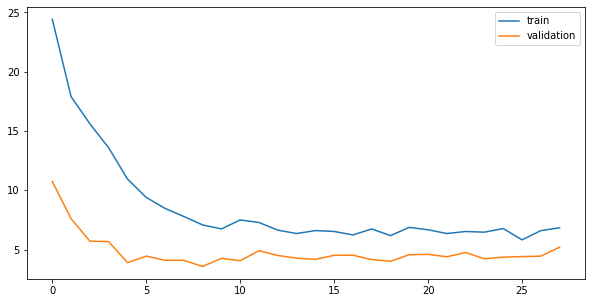

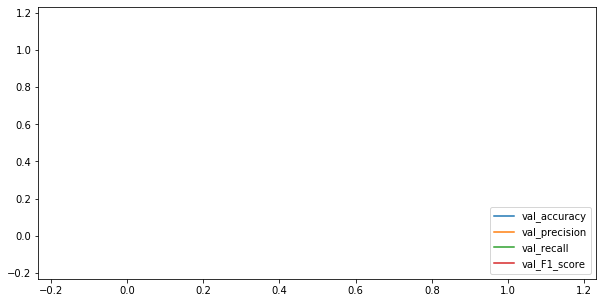

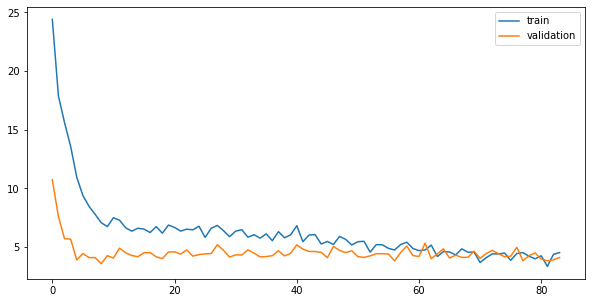

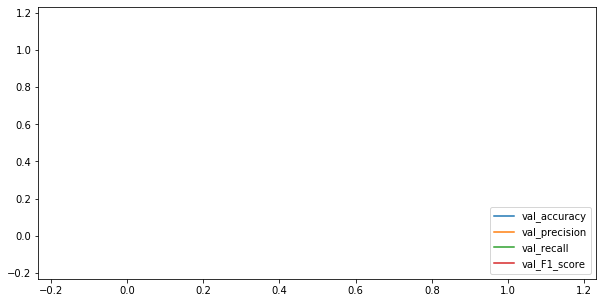

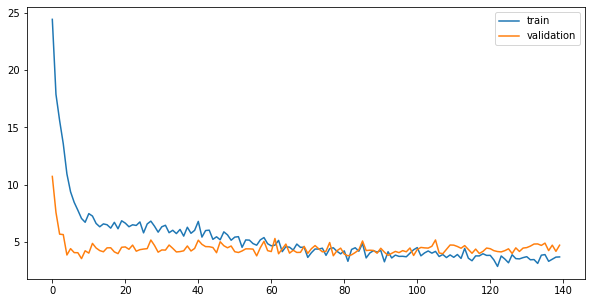

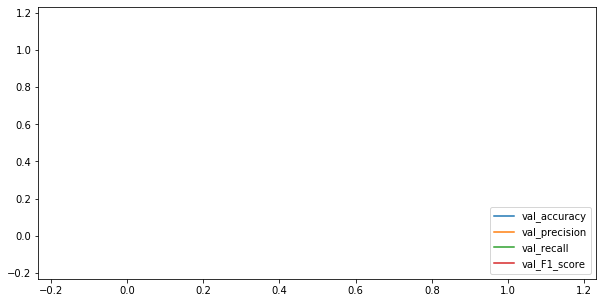

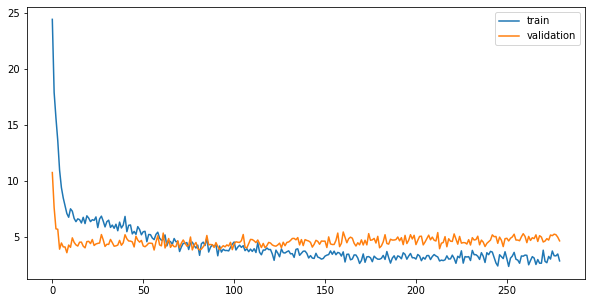

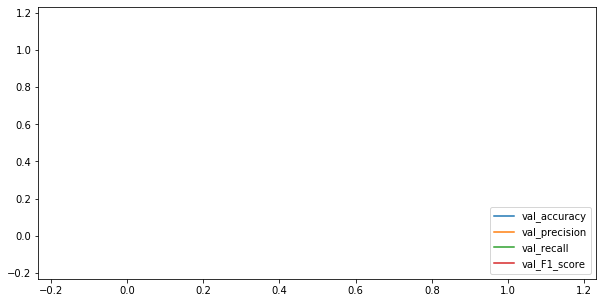

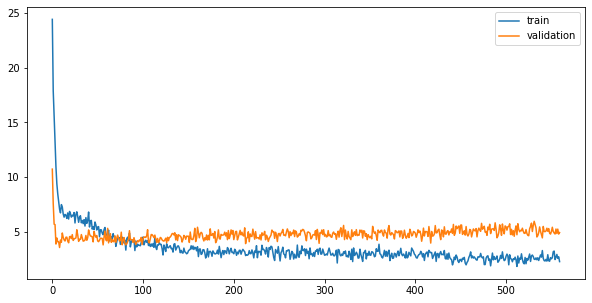

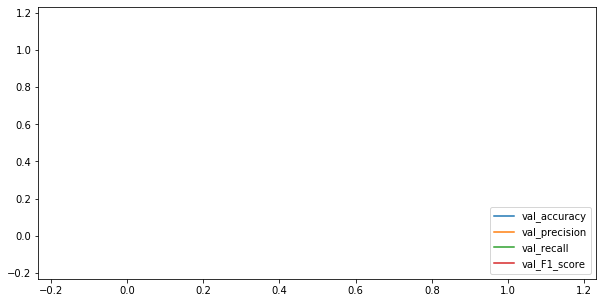

In [52]:
num_epochs = 100
total_step = train_length//500

encoder = CNNEncoder().to(DEVICE)

criterion = nn.BCELoss(reduction='mean')
params = list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

plot_dict = dict()
losses = list()
val_losses = list()
acc = list()
prec = list()
rec = list()
f1 = list()

t0 = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        encoder.train()
        encoder.zero_grad()
        
        inps, labels = next(iter(train_loader))
        
        for i in range(6):
            inp = inps[:,:,i*1000:(i+1)*1000]
            label = labels[:,:,i]
            output = encoder(inp)
            if i == 0:
                outputs = output
            else:
                outputs = torch.cat((outputs, output), 1)
        outputs = torch.unsqueeze(outputs, 1).to(DEVICE)
        labels = labels.to(DEVICE)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        # - - - Validate - - -
        with torch.no_grad():
            
            encoder.eval()

            val_inps, val_labels = next(iter(valid_loader))
            
            for i in range(6):
                val_inp = val_inps[:,:,i*1000:(i+1)*1000]
                val_label = val_labels[:,:,i]
                val_output = encoder(inp)
                if i == 0:
                    val_outputs = val_output
                else:
                    val_outputs = torch.cat((val_outputs, val_output), 1)
            val_outputs = torch.unsqueeze(val_outputs, 1).to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            
            
            val_loss = criterion(val_outputs, val_labels)
#             val_accuracy, val_precision, val_recall, val_F1_score = metric(val_outputs, val_label)
            
            
        val_losses.append(val_loss.item())
        losses.append(loss.item())
#         acc.append(val_accuracy)
#         prec.append(val_precision)
#         rec.append(val_recall)
#         f1.append(val_F1_score)
        
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f' % \
                (epoch, num_epochs, i_step, total_step, loss.item(), val_loss.item())
#         stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f accuracy : %.4f, precision : %.4f, recall : %.4f, F1_score : %.4f' % \
#                 (epoch, num_epochs, i_step, total_step, loss.item(), val_loss.item(), val_accuracy, val_precision, val_recall, val_F1_score)
        
        print('\r', stats, end="")
        
        print()
        print(val_outputs[0,:])        
        print(val_labels[0,:])
        print()
        
    print('\r', stats)
    
    plot_dict['val_losses'] = val_losses
    plot_dict['losses'] = losses
    plot_dict['acc'] = acc
    plot_dict['prec'] = prec
    plot_dict['rec'] = rec
    plot_dict['f1'] = f1
    
    if epoch == 1 or epoch == 3 or epoch == 5 or epoch%10 == 0:
        save_fig('balance', epoch, plot_dict)
    

t1 = time.time()

print('finished in {} seconds'.format(t1 - t0))

In [21]:
with torch.no_grad():
            
    encoder.eval()

    test_inp, test_label = next(iter(test_loader))
    test_inp = test_inp.to(DEVICE)
    test_label = test_label.to(DEVICE)
    test_outputs = encoder(test_inp).to(DEVICE)

    test_loss = criterion(test_outputs, test_label)
    test_accuracy, test_precision, test_recall, test_F1_score = metric(test_outputs, test_label)
        
stats = 'Loss: %.4f, accuracy : %.4f, precision : %.4f, recall : %.4f, F1_score : %.4f' % \
                (test_loss.item(), test_accuracy, test_precision, test_recall, test_F1_score)
        
print(stats)

ValueError: Using a target size (torch.Size([500, 1, 6])) that is different to the input size (torch.Size([3000, 1])) is deprecated. Please ensure they have the same size.

In [18]:
_, _, im_test_loader = load_dataset()

with torch.no_grad():
            
    encoder.eval()

    test_inp, test_label = next(iter(im_test_loader))
    test_inp = test_inp.to(DEVICE)
    test_label = test_label.to(DEVICE)
    test_outputs = encoder(test_inp).to(DEVICE)

    test_loss = criterion(test_outputs, test_label)
    test_accuracy, test_precision, test_recall, test_F1_score = metric(test_outputs, test_label)
        
stats = 'Loss: %.4f, accuracy : %.4f, precision : %.4f, recall : %.4f, F1_score : %.4f' % \
                (test_loss.item(), test_accuracy, test_precision, test_recall, test_F1_score)
        
print(stats)

Loss: 0.3289, accuracy : 0.9520, precision : 0.5789, recall : 1.0000, F1_score : 0.7333
